In [15]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [16]:
pip install torchxrayvision

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train.csv") 
test_df = pd.read_csv("/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test.csv") 
nf_df = train_df[train_df["class_name"] == "No finding"]
train_df = train_df[train_df["class_name"] != "No finding"]


In [18]:
unique_labels = train_df["class_name"].unique()
unique_labels = [label for label in unique_labels if label != "No finding"]
label_to_id = {label: i for i, label in enumerate(unique_labels)}

train_df["class_id"] = train_df["class_name"].map(label_to_id)

multi_label_df = train_df.groupby("image_id")["class_id"].apply(list).reset_index()

num_classes = len(unique_labels)
def to_multi_hot(labels):
    one_hot = np.zeros(num_classes, dtype=int)
    for label in labels:
        one_hot[label] = 1
    return one_hot

multi_label_df["multi_hot"] = multi_label_df["class_id"].apply(to_multi_hot)

multi_label_df = multi_label_df.drop(columns='class_id')
multi_label_df = multi_label_df.rename(columns={"multi_hot": "label"})
multi_label_df.to_csv("multi_label_data.csv", index=False)


In [19]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from collections import Counter, defaultdict

def handle_class_imbalance_low_duplication(multi_label_df, max_variation_ratio=0.3, min_samples_threshold=10, 
                                          max_duplication_ratio=0.2):
    """
    Balanced sampling với kiểm soát nghiêm ngặt tỉ lệ trùng lặp mẫu
    
    Parameters:
    - multi_label_df: DataFrame với cột 'image_id' và 'label'
    - max_variation_ratio: Tỉ lệ biến thiên tối đa cho phép giữa kích thước các lớp
    - min_samples_threshold: Số lượng mẫu tối thiểu cần thiết để một lớp được giữ lại
    - max_duplication_ratio: Tỉ lệ trùng lặp tối đa cho phép
    
    Returns:
    - DataFrame cân bằng với tỉ lệ trùng lặp thấp
    """
    # Convert multi-hot labels thành danh sách lớp
    multi_label_df['classes'] = multi_label_df['label'].apply(
        lambda x: np.where(x == 1)[0].tolist()
    )
    
    # Đếm số lần xuất hiện của các lớp
    class_counts = {}
    for classes in multi_label_df['classes']:
        for cls in classes:
            class_counts[cls] = class_counts.get(cls, 0) + 1
    
    # In phân phối lớp ban đầu
    print("Phân phối lớp ban đầu:")
    for cls, count in sorted(class_counts.items()):
        print(f"Lớp {cls}: {count}")
    
    # Xác định lớp hiếm để loại bỏ
    rare_classes = [cls for cls, count in class_counts.items() if count < min_samples_threshold]
    
    if rare_classes:
        print(f"\nLoại bỏ {len(rare_classes)} lớp hiếm với ít hơn {min_samples_threshold} mẫu: {rare_classes}")
        
        # Loại bỏ lớp hiếm khỏi tập dữ liệu
        def remove_rare_classes(classes_list):
            return [cls for cls in classes_list if cls not in rare_classes]
        
        multi_label_df['classes'] = multi_label_df['classes'].apply(remove_rare_classes)
        
        # Loại bỏ mẫu không còn lớp nào
        multi_label_df = multi_label_df[multi_label_df['classes'].apply(len) > 0].reset_index(drop=True)
        
        # Tạo ánh xạ lớp mới để xóa các lớp hiếm khỏi vector label
        valid_classes = sorted([cls for cls in class_counts.keys() if cls not in rare_classes])
        class_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(valid_classes)}
        
        # Cập nhật danh sách lớp với chỉ số mới
        multi_label_df['classes'] = multi_label_df['classes'].apply(
            lambda x: [class_mapping[cls] for cls in x]
        )
        
        # Cập nhật vector nhãn với kích thước mới (loại bỏ các cột tương ứng với lớp hiếm)
        num_remaining_classes = len(valid_classes)
        
        def update_label_vector(classes):
            multi_hot = np.zeros(num_remaining_classes, dtype=int)
            for cls in classes:
                multi_hot[cls] = 1
            return multi_hot
        
        multi_label_df['label'] = multi_label_df['classes'].apply(update_label_vector)
        
        # Cập nhật số lượng lớp
        class_counts = {}
        for classes in multi_label_df['classes']:
            for cls in classes:
                class_counts[cls] = class_counts.get(cls, 0) + 1
    
    # Tính số lượng trung vị của lớp
    class_counts_list = list(class_counts.values())
    if not class_counts_list:
        print("Không còn lớp nào sau khi lọc. Vui lòng giảm ngưỡng min_samples_threshold.")
        return multi_label_df[['image_id', 'label']]
    
    median_count = np.median(class_counts_list)
    
    min_target = int(median_count * (1 - max_variation_ratio))
    max_target = int(median_count * (1 + max_variation_ratio))
    
    print(f"\nMục tiêu cân bằng: min={min_target}, median={median_count}, max={max_target}")
    
    # --- PHƯƠNG PHÁP CẢI TIẾN: CÂN BẰNG TOÀN CỤC THAY VÌ TỪNG LỚP ---
    
    # Chuẩn bị dữ liệu
    remaining_classes = sorted(class_counts.keys())
    
    # Khởi tạo bộ đếm cho mỗi lớp
    class_sample_counts = {cls: 0 for cls in remaining_classes}
    
    # Theo dõi số lần mỗi mẫu được chọn
    sample_usage_count = defaultdict(int)
    
    # Tính trọng số ban đầu cho mỗi mẫu (mẫu thuộc nhiều lớp còn thiếu sẽ có trọng số cao hơn)
    def calculate_sample_weight(row, class_sample_counts, targets):
        if sample_usage_count[row['image_id']] >= max(2, int(1/max_duplication_ratio)):
            return 0.0  # Không chọn mẫu đã được sử dụng quá nhiều lần
            
        # Tính điểm dựa trên các lớp còn thiếu mẫu
        score = 0
        for cls in row['classes']:
            if cls in remaining_classes:
                # Lớp càng thiếu mẫu, càng ưu tiên cao
                deficit = max(0, targets[cls] - class_sample_counts[cls])
                score += deficit
                
        # Giảm điểm nếu mẫu đã được chọn nhiều lần
        score = score / (1 + sample_usage_count[row['image_id']])
        
        return score
    
    # Tạo targets cho mỗi lớp (midpoint giữa min và max)
    targets = {cls: min(max_target, max(min_target, class_counts[cls])) for cls in remaining_classes}
    
    # Tạo DataFrame kết quả
    result_df = pd.DataFrame()
    
    # Tiếp tục cho đến khi tất cả các lớp đạt đến mục tiêu hoặc không thể cải thiện thêm
    prev_total_samples = -1
    total_samples = 0
    
    while total_samples > prev_total_samples:
        prev_total_samples = total_samples
        
        # Tính toán trọng số cho mỗi mẫu
        multi_label_df['weight'] = multi_label_df.apply(
            lambda row: calculate_sample_weight(row, class_sample_counts, targets), axis=1)
        
        # Sắp xếp theo trọng số giảm dần
        sorted_samples = multi_label_df.sort_values('weight', ascending=False).reset_index(drop=True)
        
        # Loại bỏ các mẫu không còn giá trị (weight = 0)
        sorted_samples = sorted_samples[sorted_samples['weight'] > 0]
        
        if len(sorted_samples) == 0:
            break
            
        # Chọn mẫu tốt nhất
        best_sample = sorted_samples.iloc[0].copy()
        
        # Cập nhật bộ đếm
        for cls in best_sample['classes']:
            if cls in remaining_classes:
                class_sample_counts[cls] += 1
                
        # Cập nhật số lần sử dụng
        sample_usage_count[best_sample['image_id']] += 1
        
        # Thêm vào kết quả
        result_df = pd.concat([result_df, pd.DataFrame([best_sample])], ignore_index=True)
        
        # Cập nhật tổng số mẫu
        total_samples = sum(class_sample_counts.values())
        
        # Kiểm tra xem tất cả các lớp đã đạt mục tiêu chưa
        all_targets_met = True
        for cls in remaining_classes:
            if class_sample_counts[cls] < min_target:
                all_targets_met = False
                break
                
        if all_targets_met:
            break
    
    # Loại bỏ cột tạm thời
    result_df = result_df.drop(columns=['weight'], errors='ignore')
    
    # Tạo DataFrame chỉ với các cột cần thiết
    balanced_df = result_df[['image_id', 'label', 'classes']].copy()
    
    # Tính toán thống kê trùng lặp
    duplication_counts = balanced_df['image_id'].value_counts()
    max_duplication = duplication_counts.max() if not duplication_counts.empty else 0
    avg_duplication = duplication_counts.mean() if not duplication_counts.empty else 0
    unique_samples = balanced_df.drop_duplicates(subset=['image_id'])
    
    print("\nThống kê trùng lặp:")
    print(f"Tổng số mẫu: {len(balanced_df)}")
    print(f"Số mẫu duy nhất: {len(unique_samples)}")
    if len(balanced_df) > 0:
        print(f"Tỉ lệ trùng lặp: {(len(balanced_df) - len(unique_samples)) / len(balanced_df):.2f}")
    print(f"Số lần trùng lặp tối đa cho một mẫu: {max_duplication}")
    print(f"Số lần trùng lặp trung bình: {avg_duplication:.2f}")
    
    # Phân tích phân phối lớp cuối cùng
    print("\nPhân phối lớp cuối cùng:")
    final_class_counts = {}
    for classes in balanced_df['classes']:
        for cls in classes:
            final_class_counts[cls] = final_class_counts.get(cls, 0) + 1
    
    # Sắp xếp và in phân phối cuối cùng
    sorted_final_counts = sorted(final_class_counts.items())
    for cls, count in sorted_final_counts:
        print(f"Lớp {cls}: {count}")
    
    # Phân tích biến thiên
    final_counts = list(final_class_counts.values())
    if final_counts:
        min_count = min(final_counts)
        max_count = max(final_counts)
        actual_variation = (max_count - min_count) / median_count if median_count > 0 else 0
        
        print(f"\nKích thước lớp trung vị: {median_count}")
        print(f"Kích thước lớp tối thiểu: {min_count}")
        print(f"Kích thước lớp tối đa: {max_count}")
        print(f"Tỉ lệ biến thiên thực tế: {actual_variation:.2f}")
    
    # Loại bỏ cột tạm thời
    balanced_df = balanced_df.drop(columns=['classes'])
    
    return balanced_df[['image_id', 'label']]

# Ví dụ sử dụng
balanced_df = handle_class_imbalance_low_duplication(
    multi_label_df, 
    max_variation_ratio=0.2,
    min_samples_threshold=500,
    max_duplication_ratio=0.2
)
balanced_df.to_csv("balanced_multi_label_data.csv", index=False)

Phân phối lớp ban đầu:
Lớp 0: 2300
Lớp 1: 3067
Lớp 2: 1981
Lớp 3: 386
Lớp 4: 826
Lớp 5: 1617
Lớp 6: 1322
Lớp 7: 186
Lớp 8: 1134
Lớp 9: 613
Lớp 10: 1032
Lớp 11: 452
Lớp 12: 353
Lớp 13: 96

Loại bỏ 5 lớp hiếm với ít hơn 500 mẫu: [12, 3, 11, 7, 13]

Mục tiêu cân bằng: min=1057, median=1322.0, max=1586

Thống kê trùng lặp:
Tổng số mẫu: 2900
Số mẫu duy nhất: 2306
Tỉ lệ trùng lặp: 0.20
Số lần trùng lặp tối đa cho một mẫu: 3
Số lần trùng lặp trung bình: 1.26

Phân phối lớp cuối cùng:
Lớp 0: 1586
Lớp 1: 1920
Lớp 2: 1678
Lớp 3: 1057
Lớp 4: 1664
Lớp 5: 1444
Lớp 6: 1169
Lớp 7: 1057
Lớp 8: 1069

Kích thước lớp trung vị: 1322.0
Kích thước lớp tối thiểu: 1057
Kích thước lớp tối đa: 1920
Tỉ lệ biến thiên thực tế: 0.65


In [20]:
balanced_df.shape

(2900, 2)

In [21]:
balanced_df

,image_id,label
0,b1d44013e0b4fab1d38af22901e312c4,"[1, 1, 1, 0, 1, 1, 1, 1, 1]"
1,7d0e636b3ef2ccbb0c67b3243a1478ce,"[1, 1, 1, 1, 1, 1, 1, 0, 1]"
2,011ae9520e81f1efe71c9d954ec07d09,"[1, 1, 1, 1, 1, 1, 1, 1, 0]"
3,2c475d89c90a50567ba0cf5ddd62f68a,"[1, 1, 1, 1, 1, 1, 1, 0, 1]"
4,046ad82db74a4155eaff3586b0d1e068,"[1, 1, 1, 0, 1, 1, 1, 1, 1]"
...,...,...
2895,4d911f55a3576833aa411f5718c8021e,"[0, 0, 1, 0, 1, 0, 0, 1, 0]"
2896,f5f1591393eb38f422ba01ece830b176,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
2897,4462595f31d1a2c5aac2b3a8a49536d4,"[0, 0, 0, 1, 0, 0, 0, 0, 0]"
2898,2f3bb25eb6ae1a19b982c6ba56f725e2,"[0, 0, 0, 0, 1, 0, 0, 1, 0]"


In [22]:
balanced_df_no_dup = balanced_df.drop_duplicates(subset=['image_id'])
balanced_df_no_dup.shape

(2306, 2)

Kích thước ảnh: (512, 512)


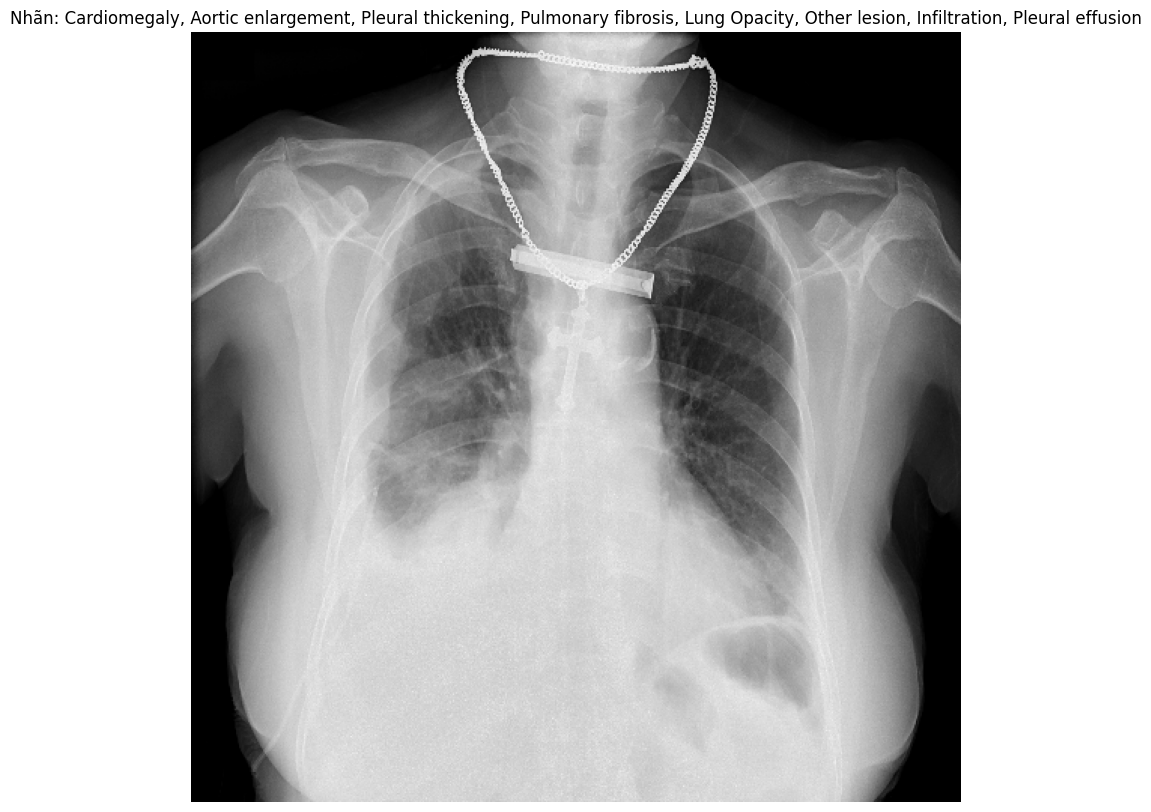

Kích thước ảnh: (512, 512)


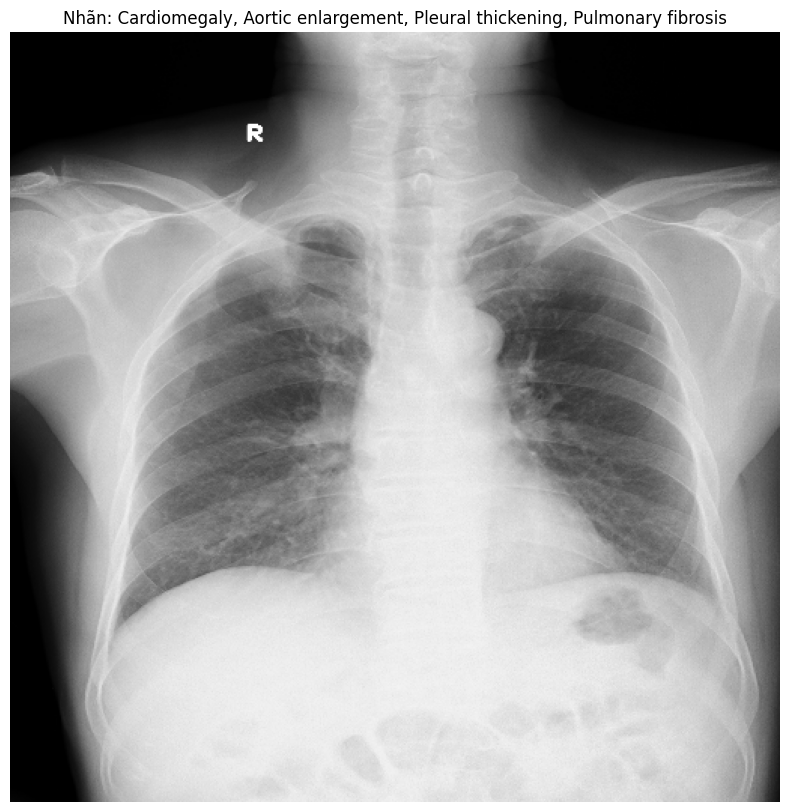

In [23]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import ast

# Mapping ID -> Label
id_to_label = {
    0: 'Cardiomegaly',
    1: 'Aortic enlargement',
    2: 'Pleural thickening',
    3: 'Nodule/Mass',
    4: 'Pulmonary fibrosis',
    5: 'Lung Opacity',
    6: 'Other lesion',
    7: 'Infiltration',
    8: 'Pleural effusion'
}


def display_image_with_labels(multi_label_df, image_dir, index=None, image_id=None):
    if index is not None:
        if index >= len(multi_label_df):
            print(f"Index {index} vượt quá số lượng ảnh ({len(multi_label_df)}).")
            return
        image_id = multi_label_df.iloc[index]["image_id"]
    elif image_id is None:
        print("Cần cung cấp `index` hoặc `image_id`.")
        return

    # Xây dựng đường dẫn ảnh
    image_path = os.path.join(image_dir, image_id + ".png")

    # Kiểm tra xem ảnh có tồn tại không
    if not os.path.exists(image_path):
        print(f"Không tìm thấy ảnh: {image_path}")
        return

    # Lấy nhãn của ảnh
    image_labels = multi_label_df[multi_label_df["image_id"] == image_id]["label"].values

    # Xử lý multi-hot encoding thành danh sách nhãn bệnh
    if len(image_labels) > 0:
        multi_hot = image_labels[0]
        if isinstance(multi_hot, str):  # Nếu là chuỗi, chuyển thành danh sách
            try:
                multi_hot = ast.literal_eval(multi_hot)
            except (ValueError, SyntaxError):
                print(f"Lỗi chuyển đổi nhãn: {multi_hot}")
                multi_hot = np.zeros(len(id_to_label), dtype=int)
        labels = [id_to_label[i] for i, value in enumerate(multi_hot) if value == 1]
    else:
        labels = ["Không có nhãn"]

    # Hiển thị ảnh
    img = plt.imread(image_path)
    print(f"Kích thước ảnh: {img.shape}")

    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap="gray")
    plt.axis("off") 
    plt.title(f"Nhãn: {', '.join(labels)}" if labels else "Không có nhãn")
    plt.show()




image_dir = "/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train"

display_image_with_labels(balanced_df, image_dir, index=10)
display_image_with_labels(balanced_df, image_dir, image_id="0007d316f756b3fa0baea2ff514ce945")


Kích thước ảnh: (512, 512)


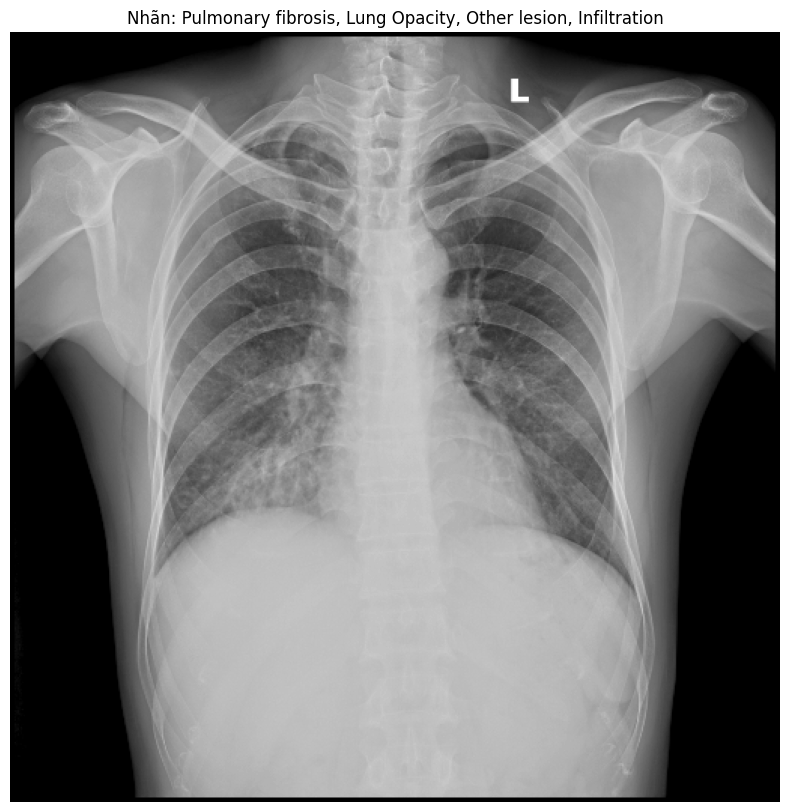

In [24]:
display_image_with_labels(balanced_df, image_dir, index=2800)

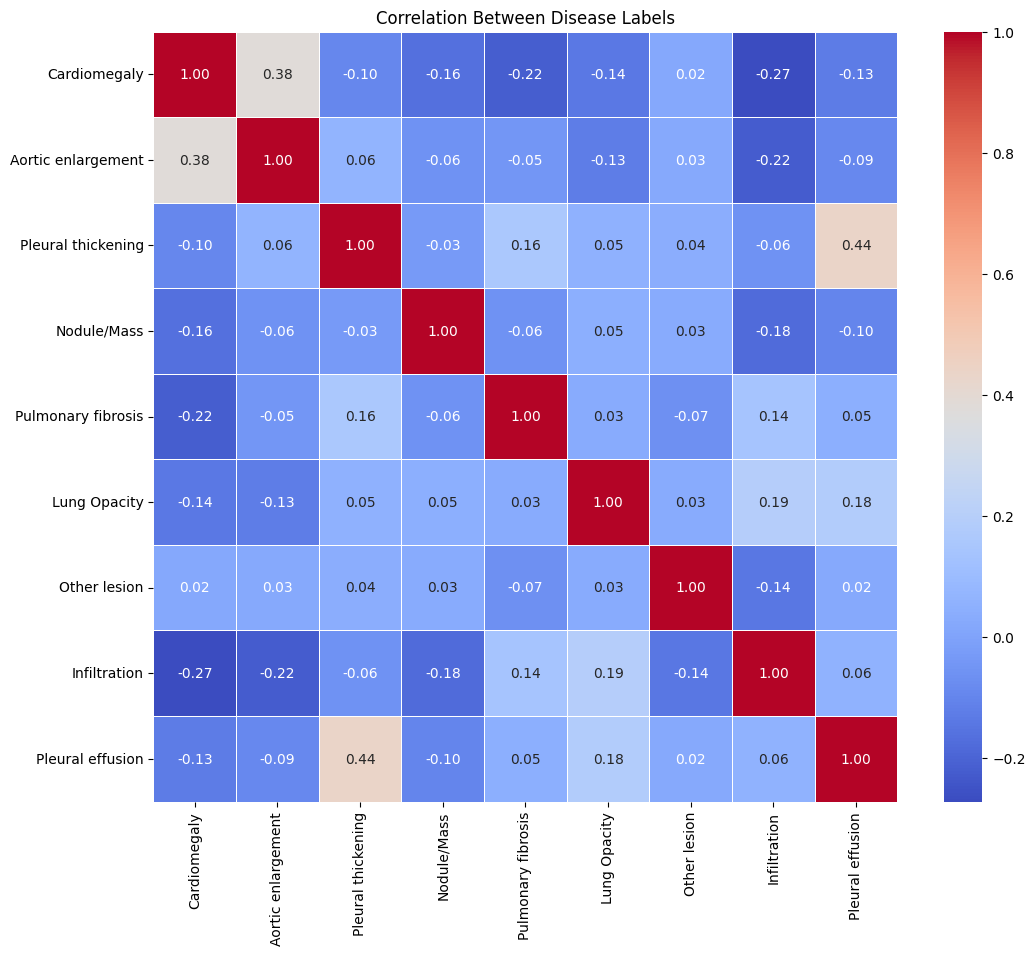

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

multi_hot_data = np.array(balanced_df['label'].tolist(), dtype=np.float64) 

correlation_matrix = np.corrcoef(multi_hot_data, rowvar=False)

labels = [
    'Cardiomegaly',
    'Aortic enlargement',
    'Pleural thickening',
    'Nodule/Mass',
    'Pulmonary fibrosis',
    'Lung Opacity',
    'Other lesion',
    'Infiltration',
    'Pleural effusion'
]

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            xticklabels=labels, yticklabels=labels, linewidths=0.5)
plt.title("Correlation Between Disease Labels")
plt.show()

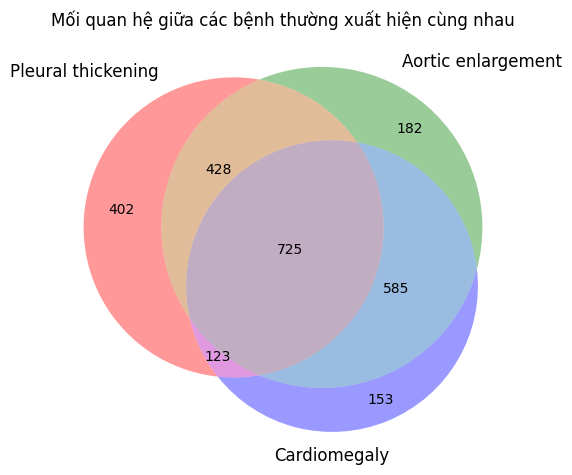

In [26]:
from matplotlib_venn import venn3

co_occurrence_matrix = np.dot(multi_hot_data.T, multi_hot_data)
df_co = pd.DataFrame(co_occurrence_matrix, index=labels, columns=labels)

co_pairs = []
for i in range(len(labels)):
    for j in range(i + 1, len(labels)):  
        co_pairs.append((df_co.iloc[i, j], labels[i], labels[j]))

co_pairs = sorted(co_pairs, reverse=True, key=lambda x: x[0])

top_3_labels = set()
for pair in co_pairs:
    top_3_labels.add(pair[1])
    top_3_labels.add(pair[2])
    if len(top_3_labels) >= 3:
        break
top_3_labels = list(top_3_labels)[:3]
top_3_indices = [labels.index(l) for l in top_3_labels]
venn_data = {label: set(np.where(multi_hot_data[:, idx] == 1)[0]) for label, idx in zip(top_3_labels, top_3_indices)}
plt.figure(figsize=(6, 6))
venn3([venn_data[top_3_labels[0]], venn_data[top_3_labels[1]], venn_data[top_3_labels[2]]], top_3_labels)
plt.title("Mối quan hệ giữa các bệnh thường xuất hiện cùng nhau")
plt.show()

In [27]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import f1_score, precision_score, recall_score
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torchxrayvision as xrv

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

IMG_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
TAU = 0.5
P = 0.2
NUM_HEADS = 8
NUM_SUB_GRAPHS = 32

class XRayDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_names=None, transform=None, is_test=False):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        self.label_names = label_names
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Lấy đường dẫn ảnh
        img_name = os.path.join(self.img_dir, self.data.iloc[idx]['image_id'] + '.png')
        image = Image.open(img_name).convert('L')
        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, self.data.iloc[idx]['image_id']

        label_str = self.data.iloc[idx]['label']
        label = np.array([int(x) for x in label_str.strip('[]').replace(',', '').split()], dtype=np.float32)
        label = torch.FloatTensor(label)  # Chuyển đổi thành tensor
        return image, label



train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


Using device: cuda


Tổng số lớp: 9
Danh sách nhãn: ['Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Other lesion', 'Infiltration', 'Pleural effusion']


Evaluating: 100%|██████████| 55/55 [00:08<00:00,  6.78it/s]


Epoch 1/30:
Train Loss: 1.0106, Val Loss: 0.7396
Val F1: 0.4561, Val Precision: 0.6539, Val Recall: 0.3502
Saved best model with F1: 0.4561


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


Epoch 2/30:
Train Loss: 0.6832, Val Loss: 0.9445
Val F1: 0.6680, Val Precision: 0.5120, Val Recall: 0.9606
Saved best model with F1: 0.6680


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.10it/s]


Epoch 3/30:
Train Loss: 0.6390, Val Loss: 0.6362
Val F1: 0.6086, Val Precision: 0.7028, Val Recall: 0.5366


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]


Epoch 4/30:
Train Loss: 0.5976, Val Loss: 0.6224
Val F1: 0.6068, Val Precision: 0.7538, Val Recall: 0.5079


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


Epoch 5/30:
Train Loss: 0.5572, Val Loss: 0.5892
Val F1: 0.6537, Val Precision: 0.7034, Val Recall: 0.6107


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


Epoch 6/30:
Train Loss: 0.5344, Val Loss: 0.7347
Val F1: 0.7102, Val Precision: 0.5757, Val Recall: 0.9268
Saved best model with F1: 0.7102


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


Epoch 7/30:
Train Loss: 0.5214, Val Loss: 0.5958
Val F1: 0.6835, Val Precision: 0.6748, Val Recall: 0.6924


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  6.98it/s]


Epoch 8/30:
Train Loss: 0.5111, Val Loss: 0.5449
Val F1: 0.6840, Val Precision: 0.7636, Val Recall: 0.6194


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


Epoch 9/30:
Train Loss: 0.4523, Val Loss: 0.6131
Val F1: 0.6834, Val Precision: 0.7487, Val Recall: 0.6285


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


Epoch 10/30:
Train Loss: 0.4385, Val Loss: 0.6835
Val F1: 0.6357, Val Precision: 0.7966, Val Recall: 0.5289


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]


Epoch 11/30:
Train Loss: 0.4076, Val Loss: 0.7005
Val F1: 0.6563, Val Precision: 0.7130, Val Recall: 0.6080


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


Epoch 12/30:
Train Loss: 0.3766, Val Loss: 0.6906
Val F1: 0.6772, Val Precision: 0.6804, Val Recall: 0.6740


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.03it/s]


Epoch 13/30:
Train Loss: 0.2841, Val Loss: 0.5410
Val F1: 0.7663, Val Precision: 0.7444, Val Recall: 0.7896
Saved best model with F1: 0.7663


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.08it/s]


Epoch 14/30:
Train Loss: 0.2532, Val Loss: 0.6315
Val F1: 0.7213, Val Precision: 0.8060, Val Recall: 0.6527


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.05it/s]


Epoch 15/30:
Train Loss: 0.2030, Val Loss: 0.6513
Val F1: 0.7462, Val Precision: 0.7517, Val Recall: 0.7409


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.10it/s]


Epoch 16/30:
Train Loss: 0.1901, Val Loss: 0.6454
Val F1: 0.7542, Val Precision: 0.7777, Val Recall: 0.7321


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]


Epoch 17/30:
Train Loss: 0.1730, Val Loss: 1.1065
Val F1: 0.7438, Val Precision: 0.6260, Val Recall: 0.9161


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.10it/s]


Epoch 18/30:
Train Loss: 0.1294, Val Loss: 0.6362
Val F1: 0.7785, Val Precision: 0.7682, Val Recall: 0.7891
Saved best model with F1: 0.7785


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.02it/s]


Epoch 19/30:
Train Loss: 0.1010, Val Loss: 0.6892
Val F1: 0.7705, Val Precision: 0.7879, Val Recall: 0.7539


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]


Epoch 20/30:
Train Loss: 0.0891, Val Loss: 0.6915
Val F1: 0.7883, Val Precision: 0.7598, Val Recall: 0.8189
Saved best model with F1: 0.7883


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]


Epoch 21/30:
Train Loss: 0.0860, Val Loss: 0.7933
Val F1: 0.7544, Val Precision: 0.8344, Val Recall: 0.6884


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.09it/s]


Epoch 22/30:
Train Loss: 0.0713, Val Loss: 0.7217
Val F1: 0.7926, Val Precision: 0.7855, Val Recall: 0.7997
Saved best model with F1: 0.7926


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  6.96it/s]


Epoch 23/30:
Train Loss: 0.0649, Val Loss: 0.7295
Val F1: 0.7919, Val Precision: 0.7772, Val Recall: 0.8072


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.03it/s]


Epoch 24/30:
Train Loss: 0.0535, Val Loss: 0.7260
Val F1: 0.7908, Val Precision: 0.7958, Val Recall: 0.7859


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.02it/s]


Epoch 25/30:
Train Loss: 0.0552, Val Loss: 0.7635
Val F1: 0.7855, Val Precision: 0.7821, Val Recall: 0.7888


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.00it/s]


Epoch 26/30:
Train Loss: 0.0446, Val Loss: 0.7306
Val F1: 0.7928, Val Precision: 0.7892, Val Recall: 0.7965
Saved best model with F1: 0.7928


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.03it/s]


Epoch 27/30:
Train Loss: 0.0393, Val Loss: 0.7547
Val F1: 0.7851, Val Precision: 0.8029, Val Recall: 0.7680


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


Epoch 28/30:
Train Loss: 0.0406, Val Loss: 0.7520
Val F1: 0.7819, Val Precision: 0.7901, Val Recall: 0.7739


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.08it/s]


Epoch 29/30:
Train Loss: 0.0382, Val Loss: 0.8015
Val F1: 0.7878, Val Precision: 0.7636, Val Recall: 0.8136


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.06it/s]


Epoch 30/30:
Train Loss: 0.0345, Val Loss: 0.7479
Val F1: 0.7859, Val Precision: 0.7903, Val Recall: 0.7816
Training history plot saved to results/training_history.png


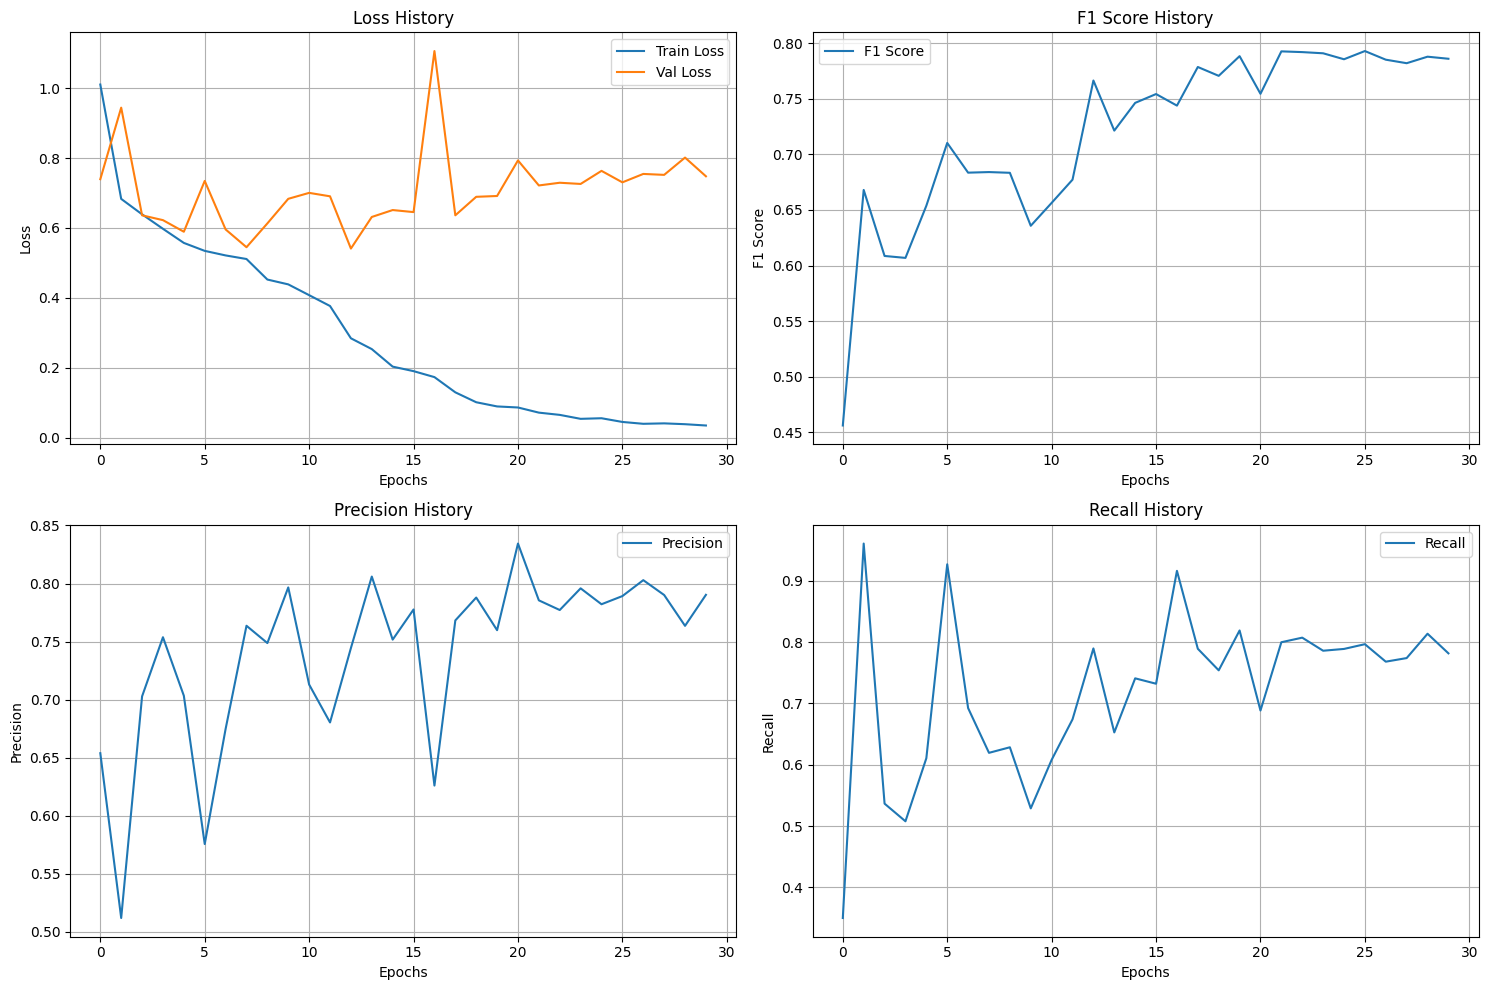

Loaded best model with F1: 0.7928

=== Detailed Model Evaluation ===
Generating detailed metrics and visualizations...


Evaluating: 100%|██████████| 55/55 [00:07<00:00,  7.04it/s]


Overall Accuracy: 0.7972
Overall Precision: 0.7878
Overall Recall: 0.7891
Overall F1 Score: 0.7885

Classification Report:
                    precision    recall  f1-score   support

      Cardiomegaly       0.89      0.85      0.87       452
Aortic enlargement       0.86      0.89      0.88       561
Pleural thickening       0.76      0.79      0.77       498
       Nodule/Mass       0.74      0.73      0.73       335
Pulmonary fibrosis       0.80      0.79      0.80       501
      Lung Opacity       0.71      0.76      0.73       442
      Other lesion       0.63      0.62      0.63       335
      Infiltration       0.77      0.81      0.79       318
  Pleural effusion       0.89      0.78      0.83       313

         micro avg       0.79      0.79      0.79      3755
         macro avg       0.78      0.78      0.78      3755
      weighted avg       0.79      0.79      0.79      3755
       samples avg       0.77      0.78      0.75      3755

Detailed evaluation completed and 

Predicting: 100%|██████████| 188/188 [00:26<00:00,  7.14it/s]


Predictions saved to results/predictions.csv


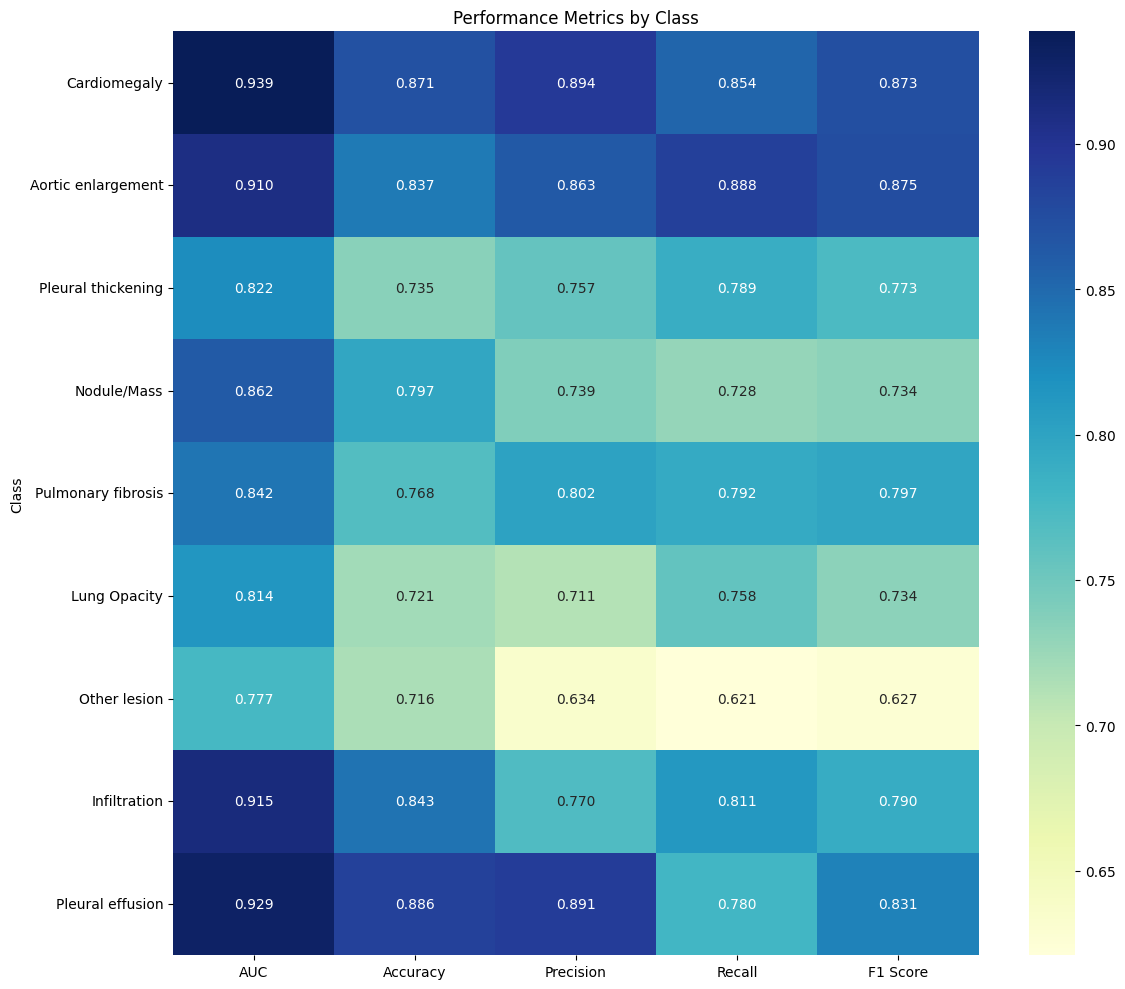

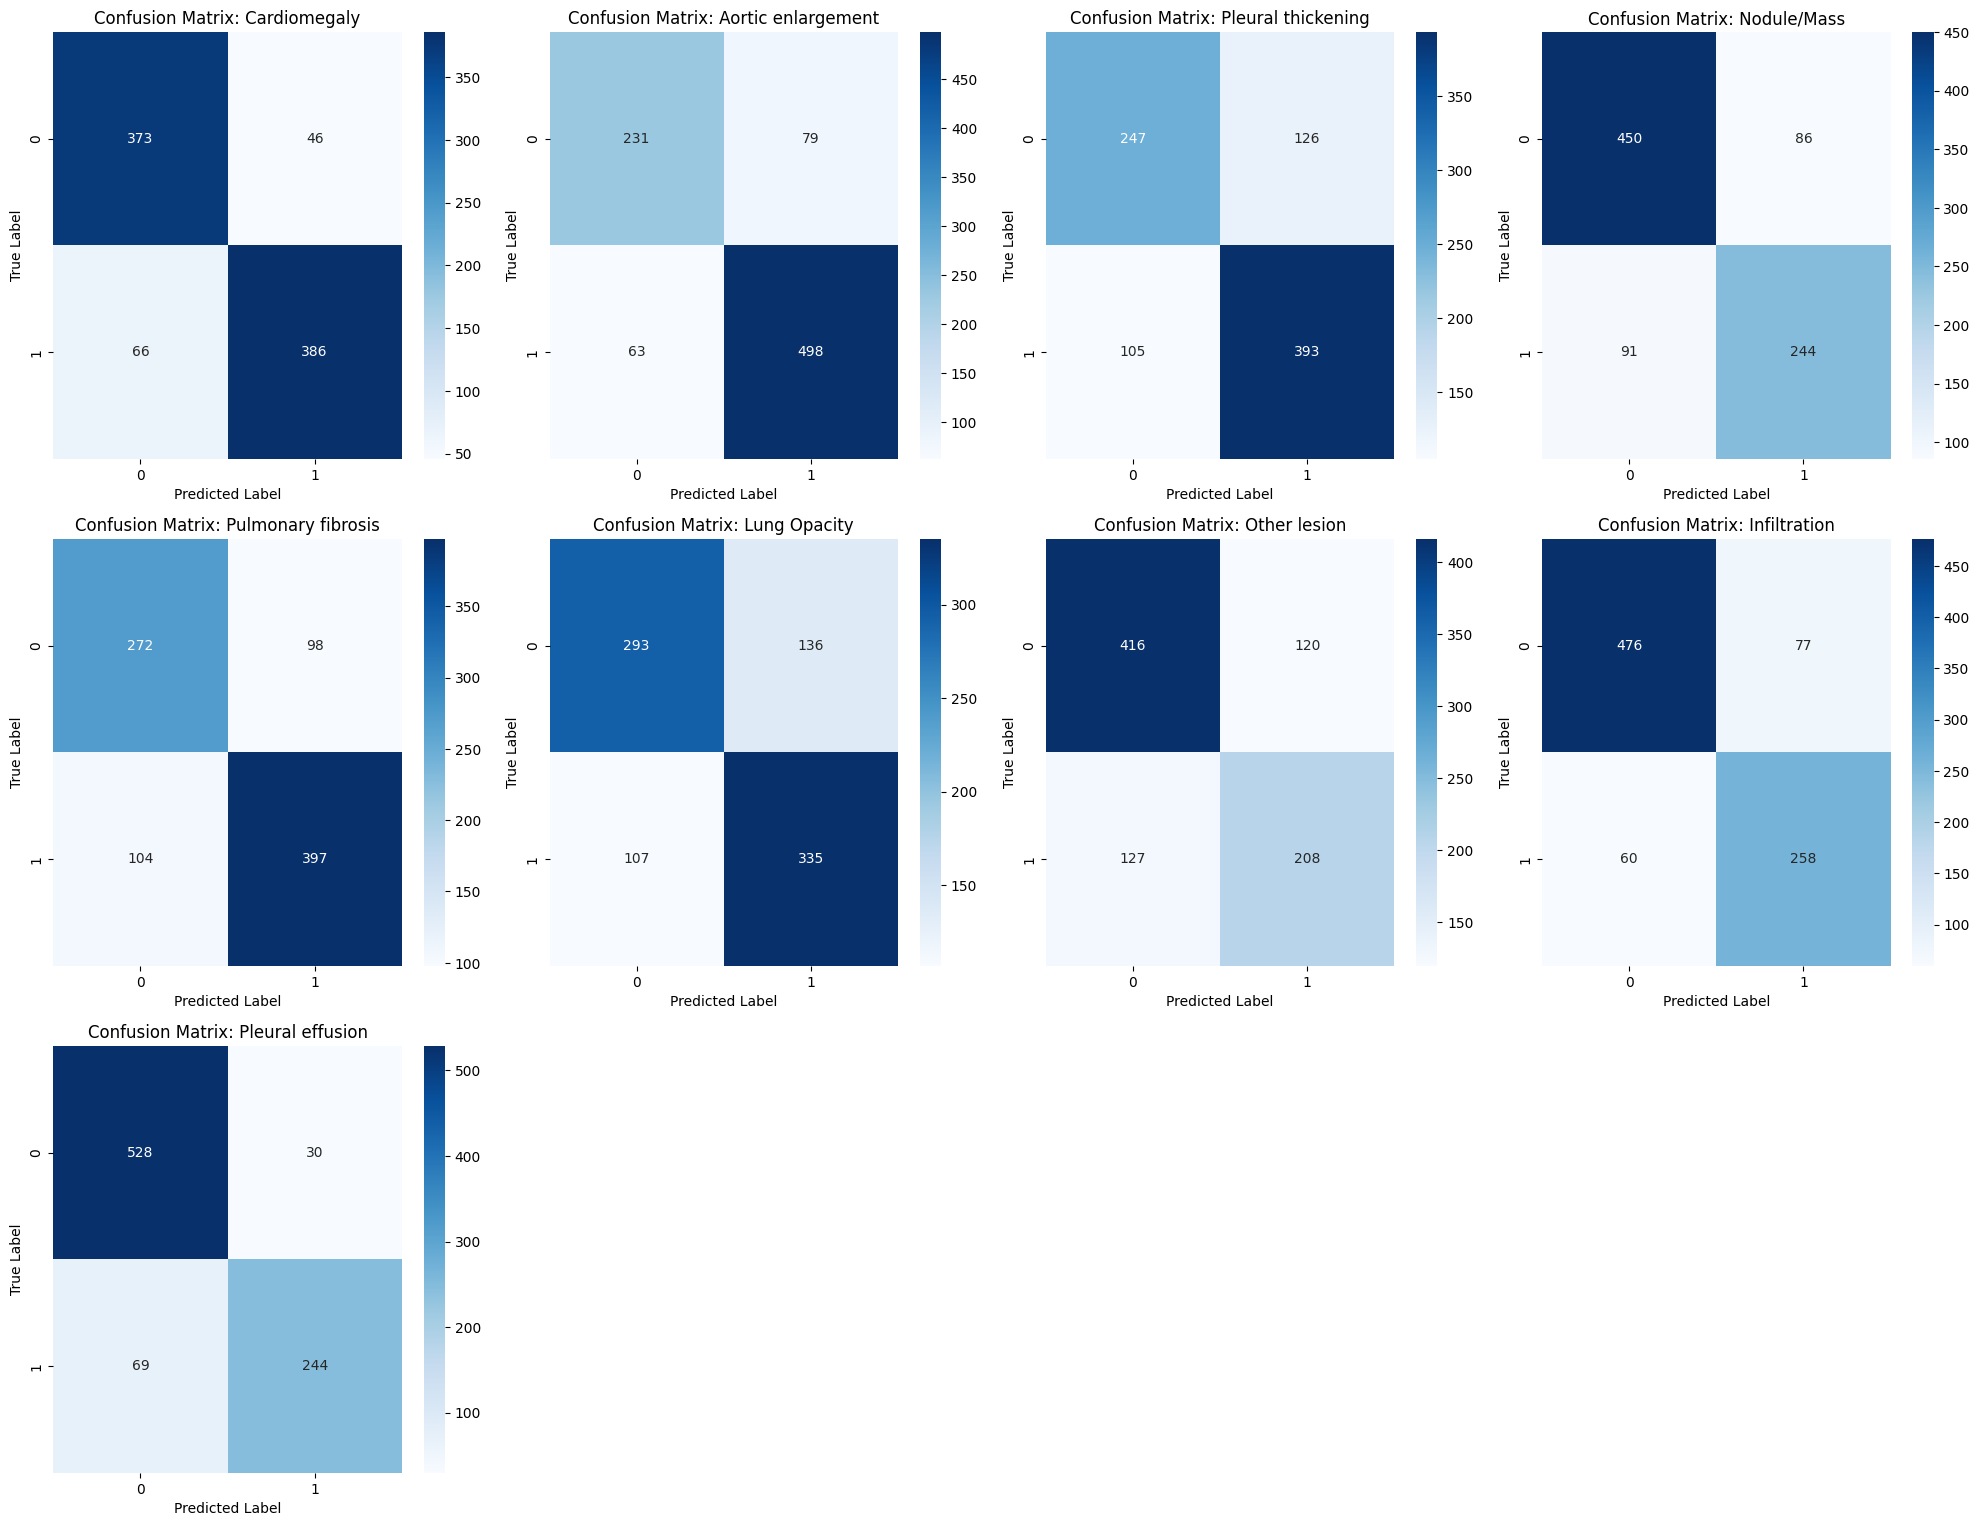

In [28]:
# from torchvision import models
# import torchxrayvision as xrv
# class FeatureExtractor(nn.Module):
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
#         densenet = xrv.models.DenseNet(weights="chex")
#         self.features = densenet.features
#         self.global_pool = nn.AdaptiveAvgPool2d(1)
    
#     def forward(self, x):
#         x = self.features(x)
#         x = self.global_pool(x)
#         x = x.view(x.size(0), -1)
#         return x
from torchvision import models
import torch.nn as nn

# class FeatureExtractor(nn.Module):
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
#         resnet = models.resnet50(pretrained=True)
#         self.features = nn.Sequential(*list(resnet.children())[:-2])  # Loại bỏ lớp FC
#         self.global_pool = nn.AdaptiveAvgPool2d(1)
    
#     def forward(self, x):
#         x = self.features(x)
#         x = self.global_pool(x)
#         x = x.view(x.size(0), -1)
#         return x

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # Modify the first convolution layer to accept 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize using the pretrained weights, averaging across the channels
        with torch.no_grad():
            self.conv1.weight.data = resnet.conv1.weight.data.sum(dim=1, keepdim=True)
        
        # Use the rest of the ResNet layers
        modules = list(resnet.children())[1:-2]  # Skip the first conv and the FC layers
        self.features = nn.Sequential(self.conv1, *modules)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

class GraphAttentionTransformerLayer(nn.Module):
    def __init__(self, n_classes, hidden_dim, n_heads):
        super(GraphAttentionTransformerLayer, self).__init__()
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        
        self.attention_heads = nn.ModuleList([
            nn.ModuleDict({
                'query': nn.Linear(n_classes, hidden_dim),
                'key': nn.Linear(n_classes, hidden_dim),
                'value': nn.Linear(n_classes, hidden_dim)
            }) for _ in range(n_heads)
        ])
        
        self.output_linear = nn.Linear(hidden_dim * n_heads, n_classes)
    
    def forward(self, adj_matrix):
        attention_outputs = []
        
        for head in self.attention_heads:
            Q = head['query'](adj_matrix)
            K = head['key'](adj_matrix)
            V = head['value'](adj_matrix)
            
            attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_dim ** 0.5)
            attention_probs = F.softmax(attention_scores, dim=-1)
            
            context_layer = torch.matmul(attention_probs, V)
            attention_outputs.append(context_layer)
        
        concat_attention = torch.cat(attention_outputs, dim=-1)
        
        output = self.output_linear(concat_attention)
        
        return output

class GraphConvolutionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolutionLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, input_features, adj_matrix):
        adj_with_self_loops = adj_matrix + torch.eye(adj_matrix.size(0), device=adj_matrix.device)
        deg = torch.sum(adj_with_self_loops, dim=1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.
        
        norm_adj = torch.mul(
            torch.mul(adj_with_self_loops, deg_inv_sqrt.unsqueeze(1)),
            deg_inv_sqrt.unsqueeze(0)
        )
        
        support = torch.matmul(input_features, self.weight)
        output = torch.matmul(norm_adj, support)
        
        return output

class LabelRelationBranch(nn.Module):
    def __init__(self, n_classes, embedding_dim, hidden_dim, n_heads=8, n_sub_graphs=2, tau=0.5, p=0.2):
        super(LabelRelationBranch, self).__init__()
        self.n_classes = n_classes
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.tau = tau
        self.p = p
        
        self.tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
        self.biobert = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
        
        self.graph_transformer_layers = nn.ModuleList([
            GraphAttentionTransformerLayer(n_classes, hidden_dim, n_heads)
            for _ in range(n_sub_graphs)
        ])
        
        # self.gcn = GraphConvolutionLayer(embedding_dim, 1024)  # Thay vì 2048  # 2048 là kích thước đầu ra của ResNet50
        self.gcn = GraphConvolutionLayer(embedding_dim, 2048)
    def embed_labels(self, label_names):
        with torch.no_grad():
            encoded_input = self.tokenizer(label_names, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = self.biobert(**encoded_input)
            embeddings = outputs.last_hidden_state[:, 0, :]
            
        return embeddings
    
    def create_adjacency_matrix(self, label_embeddings):
        normalized_embeddings = F.normalize(label_embeddings, p=2, dim=1)
        cosine_sim = torch.mm(normalized_embeddings, normalized_embeddings.transpose(0, 1))
        
        binary_sim = (cosine_sim >= self.tau).float()
        
        A = torch.zeros_like(binary_sim)
        sum_row = torch.sum(binary_sim, dim=1)
        
        sum_row[sum_row == 0] = 1.0
        
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                if i != j:
                    A[i, j] = self.p * binary_sim[i, j] / sum_row[i]
                else:
                    A[i, j] = 1 - self.p
        
        return A
    
    def forward(self, label_embeddings, adj_matrix):
        transformed_adj = adj_matrix
        
        for layer in self.graph_transformer_layers:
            sub_graph = layer(transformed_adj)
            transformed_adj = torch.matmul(transformed_adj, sub_graph)
        
        output = self.gcn(label_embeddings, transformed_adj)
        
        return output

class GATN(nn.Module):
    def __init__(self, n_classes, label_names, embedding_dim=768, hidden_dim=64, n_heads=8, n_sub_graphs=2, tau=0.5, p=0.2):
        super(GATN, self).__init__()
        self.n_classes = n_classes
        self.label_names = label_names
        
        # 1. Nhánh trích xuất đặc trưng
        self.feature_extractor = FeatureExtractor()
        
        # 2. Nhánh quan hệ nhãn
        self.label_relation = LabelRelationBranch(
            n_classes=n_classes,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            n_heads=n_heads,
            n_sub_graphs=n_sub_graphs,
            tau=tau,
            p=p
        )
        
        self.register_buffer('adj_matrix', None)
        self.register_buffer('label_node_features', None)
    
    def initialize_label_relations(self):
        label_embeddings = self.label_relation.embed_labels(self.label_names)
        adj_matrix = self.label_relation.create_adjacency_matrix(label_embeddings)
        
        self.adj_matrix = adj_matrix
        self.label_node_features = label_embeddings
    
    def forward(self, x):
        image_features = self.feature_extractor(x)
        
        if self.adj_matrix is None or self.label_node_features is None:
            self.initialize_label_relations()
            
        label_representations = self.label_relation(self.label_node_features, self.adj_matrix) 
        
        scores = torch.mm(image_features, label_representations.t())
        
        return scores

def evaluate(model, dataloader, criterion, threshold=0.5):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) > threshold).float().cpu().numpy()
            labels = labels.cpu().numpy()
            
            all_preds.append(preds)
            all_labels.append(labels)
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    f1 = f1_score(all_labels, all_preds, average='micro')
    precision = precision_score(all_labels, all_preds, average='micro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='micro', zero_division=0)
    
    val_loss /= len(dataloader)
    
    return val_loss, f1, precision, recall

def predict(model, dataloader, threshold=0.5):
    model.eval()
    all_preds = []
    all_ids = []
    
    with torch.no_grad():
        for images, img_ids in tqdm(dataloader, desc="Predicting"):
            images = images.to(device)
            
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).float().cpu().numpy()
            
            all_preds.append(preds)
            all_ids.extend(img_ids)
    
    all_preds = np.vstack(all_preds)
    
    return all_preds, all_ids

def save_predictions(ids, preds, label_names, output_file):
    results = []
    
    for i, img_id in enumerate(ids):
        positive_labels = []
        for j, pred in enumerate(preds[i]):
            if pred == 1:
                positive_labels.append(label_names[j])
        
        label_str = ' '.join(positive_labels)
        results.append({'image_id': img_id, 'label': label_str})
    
    pd.DataFrame(results).to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, checkpoint_path):
    best_val_f1 = 0.0
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }
    
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        val_loss, val_f1, val_precision, val_recall = evaluate(model, val_loader, criterion)
        
        if scheduler is not None:
            scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
                'val_precision': val_precision,
                'val_recall': val_recall
            }, checkpoint_path)
            print(f"Saved best model with F1: {val_f1:.4f}")
    
    return model, history

def plot_training_history(history, save_path=None):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(history['val_f1'], label='F1 Score')
    plt.title('F1 Score History')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(history['val_precision'], label='Precision')
    plt.title('Precision History')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(history['val_recall'], label='Recall')
    plt.title('Recall History')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Training history plot saved to {save_path}")
    
    plt.show()

import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score

def main():
    train_csv = 'balanced_multi_label_data.csv'
    test_csv = '/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test.csv'
    train_img_dir = '/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/train/'
    test_img_dir = '/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/'
    
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    # Đọc dữ liệu huấn luyện để lấy các nhãn
    train_df = pd.read_csv(train_csv)
    
    label_names = [
        'Cardiomegaly',
        'Aortic enlargement',
        'Pleural thickening',
        'Nodule/Mass',
        'Pulmonary fibrosis',
        'Lung Opacity',
        'Other lesion',
        'Infiltration',
        'Pleural effusion'
    ]
    n_classes = len(label_names)
    print(f"Tổng số lớp: {n_classes}")
    print(f"Danh sách nhãn: {label_names}")
    
    train_dataset = XRayDataset(train_csv, train_img_dir, label_names, train_transform)
    test_dataset = XRayDataset(test_csv, test_img_dir, label_names, test_transform, is_test=True)
    
    train_size = int(0.7 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    
    model = GATN(
        n_classes=n_classes,
        label_names=label_names,
        hidden_dim=64,
        n_heads=NUM_HEADS,
        n_sub_graphs=NUM_SUB_GRAPHS,
        tau=TAU,
        p=P
    ).to(device)
    
    model.initialize_label_relations()
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        EPOCHS,
        checkpoint_path='checkpoints/best_model.pth'
    )
    
    plot_training_history(history, save_path='results/training_history.png')
    
    checkpoint = torch.load('checkpoints/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model with F1: {checkpoint['val_f1']:.4f}")
    
    # Add this section to use the evaluate_with_metrics function
    print("\n=== Detailed Model Evaluation ===")
    print("Generating detailed metrics and visualizations...")
    metrics = evaluate_with_metrics(model, val_loader, criterion, label_names)
    print("Detailed evaluation completed and saved to results directory.")
    
    # Continue with test predictions
    all_preds, all_ids = predict(model, test_loader)
    save_predictions(all_ids, all_preds, label_names, 'results/predictions.csv')
    
# And add the evaluate_with_metrics function as provided earlier
def evaluate_with_metrics(model, dataloader, criterion, label_names):
    model.eval()
    val_loss = 0.0
    all_preds_raw = []  # Store raw probabilities for ROC/AUC
    all_preds = []      # Store binary predictions
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(float)
            labels = labels.cpu().numpy()
            
            all_preds_raw.append(probs)
            all_preds.append(preds)
            all_labels.append(labels)
    
    all_preds_raw = np.vstack(all_preds_raw)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Per-class metrics
    per_class_metrics = {
        'auc': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    # Calculate AUC for each class
    plt.figure(figsize=(20, 15))
    
    for i, class_name in enumerate(label_names):
        # ROC Curve and AUC
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds_raw[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.subplot(4, 4, i+1)
        plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve: {class_name}')
        plt.legend(loc="lower right")
        
        # Store metrics
        per_class_metrics['auc'].append(roc_auc)
        per_class_metrics['accuracy'].append(accuracy_score(all_labels[:, i], all_preds[:, i]))
        per_class_metrics['precision'].append(precision_score(all_labels[:, i], all_preds[:, i], zero_division=0))
        per_class_metrics['recall'].append(recall_score(all_labels[:, i], all_preds[:, i], zero_division=0))
        per_class_metrics['f1'].append(f1_score(all_labels[:, i], all_preds[:, i], zero_division=0))
    
    plt.tight_layout()
    plt.savefig('results/auc_curves.png')
    plt.close()
    
    # Overall metrics
    overall_accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten())
    overall_precision = precision_score(all_labels, all_preds, average='micro', zero_division=0)
    overall_recall = recall_score(all_labels, all_preds, average='micro', zero_division=0)
    overall_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    
    # Create classification report
    report = classification_report(all_labels, all_preds, target_names=label_names, zero_division=0)
    print("\nClassification Report:")
    print(report)
    
    # Save classification report to CSV
    report_dict = classification_report(all_labels, all_preds, 
                                        target_names=label_names, 
                                        output_dict=True, 
                                        zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv('results/classification_report.csv')
    
    # Plot metrics comparison per class
    metrics_df = pd.DataFrame({
        'Class': label_names,
        'AUC': per_class_metrics['auc'],
        'Accuracy': per_class_metrics['accuracy'],
        'Precision': per_class_metrics['precision'],
        'Recall': per_class_metrics['recall'],
        'F1 Score': per_class_metrics['f1']
    })
    
    # Save metrics to CSV
    metrics_df.to_csv('results/per_class_metrics.csv', index=False)
    
    # Plot bar charts for all metrics
    plt.figure(figsize=(15, 20))
    
    # AUC Plot
    plt.subplot(5, 1, 1)
    sns.barplot(x='Class', y='AUC', data=metrics_df)
    plt.title('AUC by Class')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=np.mean(per_class_metrics['auc']), color='r', linestyle='--', label=f'Mean: {np.mean(per_class_metrics["auc"]):.3f}')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(5, 1, 2)
    sns.barplot(x='Class', y='Accuracy', data=metrics_df)
    plt.title('Accuracy by Class')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=overall_accuracy, color='r', linestyle='--', label=f'Overall: {overall_accuracy:.3f}')
    plt.legend()
    
    # Precision Plot
    plt.subplot(5, 1, 3)
    sns.barplot(x='Class', y='Precision', data=metrics_df)
    plt.title('Precision by Class')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=overall_precision, color='r', linestyle='--', label=f'Overall: {overall_precision:.3f}')
    plt.legend()
    
    # Recall Plot
    plt.subplot(5, 1, 4)
    sns.barplot(x='Class', y='Recall', data=metrics_df)
    plt.title('Recall by Class')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=overall_recall, color='r', linestyle='--', label=f'Overall: {overall_recall:.3f}')
    plt.legend()
    
    # F1 Score Plot
    plt.subplot(5, 1, 5)
    sns.barplot(x='Class', y='F1 Score', data=metrics_df)
    plt.title('F1 Score by Class')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=overall_f1, color='r', linestyle='--', label=f'Overall: {overall_f1:.3f}')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('results/metrics_by_class.png')
    plt.close()
    
    # Create heatmap of metrics
    plt.figure(figsize=(12, 10))
    metrics_heatmap = metrics_df.iloc[:, 1:].set_index(metrics_df['Class'])
    sns.heatmap(metrics_heatmap, annot=True, cmap='YlGnBu', fmt='.3f')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.savefig('results/metrics_heatmap.png')
    
    plt.figure(figsize=(20, 20))
    for i, class_name in enumerate(label_names):
        plt.subplot(4, 4, i+1)
        cm = np.array([
            [np.sum((all_labels[:, i] == 0) & (all_preds[:, i] == 0)), np.sum((all_labels[:, i] == 0) & (all_preds[:, i] == 1))],
            [np.sum((all_labels[:, i] == 1) & (all_preds[:, i] == 0)), np.sum((all_labels[:, i] == 1) & (all_preds[:, i] == 1))]
        ])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {class_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('results/confusion_matrices.png')
    
    return {
        'overall_accuracy': overall_accuracy,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'per_class_metrics': per_class_metrics,
        'metrics_df': metrics_df
    }

if __name__ == "__main__":
    main()

In [29]:
import pandas as pd
pred = pd.read_csv('results/predictions.csv')
pred[20:21]
pd.set_option('display.max_colwidth', None)
print(pred.iloc[20:30])

                            image_id  \
20  2f775125346cd62232d8e835794941c0   
21  1fae839a73abec3f3d7436fa2bce4630   
22  6f8320a9c444090bd55010537a9e7dcb   
23  da35978a37f990de5a0d68b1e9399e9e   
24  5b6707d336c733e0a8d4233bb08483c7   
25  c06b82fd93dbc1cc113b779b69b1696a   
26  bb5ffb34f5baa01ec1e47df249046609   
27  615be21de05d7049ddb1652520d7f528   
28  c4311217936b89f9dbcc6fb57e00b40d   
29  4317ccff1c5ab145abf05130c49402b0   

                                                                                                              label  
20                                                               Pleural thickening Pulmonary fibrosis Lung Opacity  
21                                            Aortic enlargement Pleural thickening Pulmonary fibrosis Infiltration  
22  Aortic enlargement Pleural thickening Nodule/Mass Pulmonary fibrosis Lung Opacity Other lesion Pleural effusion  
23                                                                     Cardiomegaly Aor

In [30]:
df = pd.read_csv('balanced_multi_label_data.csv')
df

,image_id,label
0,b1d44013e0b4fab1d38af22901e312c4,[1 1 1 0 1 1 1 1 1]
1,7d0e636b3ef2ccbb0c67b3243a1478ce,[1 1 1 1 1 1 1 0 1]
2,011ae9520e81f1efe71c9d954ec07d09,[1 1 1 1 1 1 1 1 0]
3,2c475d89c90a50567ba0cf5ddd62f68a,[1 1 1 1 1 1 1 0 1]
4,046ad82db74a4155eaff3586b0d1e068,[1 1 1 0 1 1 1 1 1]
...,...,...
2895,4d911f55a3576833aa411f5718c8021e,[0 0 1 0 1 0 0 1 0]
2896,f5f1591393eb38f422ba01ece830b176,[1 1 0 0 0 0 0 0 0]
2897,4462595f31d1a2c5aac2b3a8a49536d4,[0 0 0 1 0 0 0 0 0]
2898,2f3bb25eb6ae1a19b982c6ba56f725e2,[0 0 0 0 1 0 0 1 0]
